# Neural Style Transfer using Perceptual Losses

**Reference Paper:** https://arxiv.org/pdf/1603.08155 by Johnson et. al.

This paper consists two part
1. ImageTransformNet For style transfer
2. Image Super Resolution

I'm going to implement just the first part!


# Model Architecture

## Image Transformation Network
 *An image transformation network is a network which learns to reproduce an image for a given task. This network has three key characteristics in order to reproduce an image:*
  * Downsampling learns the semantic features of an image.
  * Upsampling learns to reproduce the image through consecutive deconvolutional layers.
  * Residual blocks help to carry information from the downsampling path to the upsampling path through concatenation.
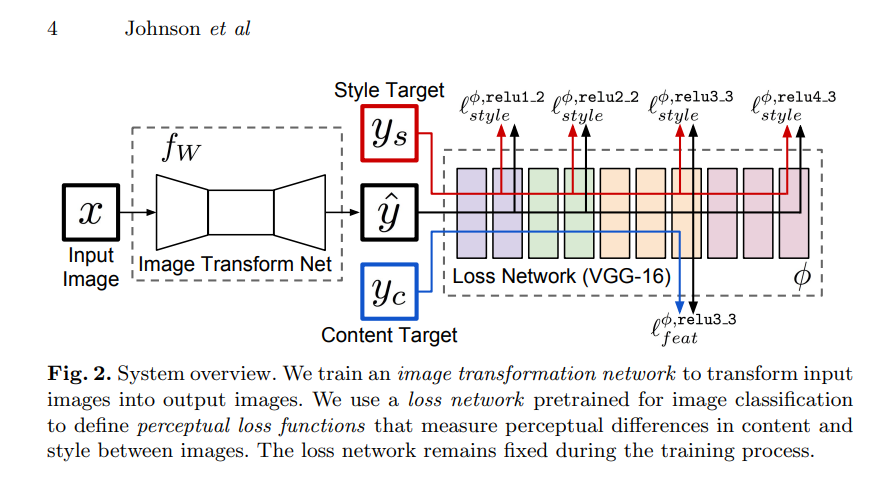

## Perceptual Loss Network
   It consists of two main loss functions
   * Feature Reconstruction Loss
   * Style Reconstruction Loss

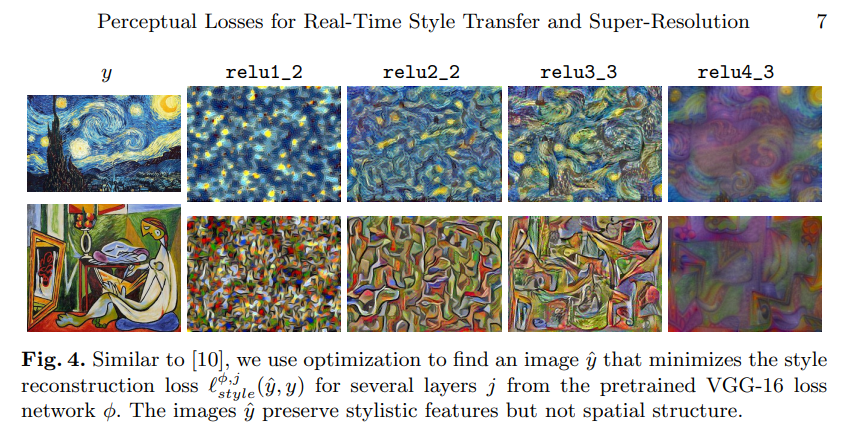

In [2]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim

from PIL import Image
from torchvision.transforms import transforms

from scripts.transformer_network import ImageTransformerNet
from utils.config import Config
from utils.utils import *


from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader

## Data

1. Content Images
2. Style Image (For now, i'm just training using a single style image)\
**Note(!)**: For multiple style images, the architecture needs to be modified accordingly!

In [11]:
## CONSTANTS
config = Config()

CONTENT_DIR = config.get('paths', 'content_dir')
STYLE_IMAGE = config.get('paths', 'style_image')
MODEL_CHECKPOINT_FILEPATH = config.get('paths', 'model_checkpoint')

INPUT_SIZE = config.get('settings', 'input_size')
TARGET_SIZE  = config.get('settings', 'target_size')

ALPHA = int(config.get('settings', 'alpha'))
BETA = int(config.get('settings', 'beta'))
LR = int(config.get('settings', 'learning_rate'))
BATCH = int(config.get('settings', 'batch_size'))
FEATURE_INDEX = int(config.get('settings', 'feature_index'))
LAYER_IDS = config.get('settings', 'layer_indices')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VGG_MEAN = torch.tensor(config.get('settings', 'vgg_mean'))
VGG_STD = torch.tensor(config.get('settings', 'vgg_std'))


# Essential Concepts used in the helper functions

## Normalization in Deep Learning

Normalization is a preprocessing step applied to images before feeding them into a deep learning model. It helps models converge faster during training by standardizing the input range.

### How Normalization Works

For each channel (R, G, B), normalization is done as:

$$
\text{Normalized Value} = \frac{\text{Pixel Value} - \text{Mean}}{\text{Standard Deviation}}
$$

Where:

- **Mean**: Average pixel value for each channel in the dataset (e.g., [0.485, 0.456, 0.406] for ImageNet).
- **Standard Deviation**: Spread of pixel values for each channel in the dataset (e.g., [0.229, 0.224, 0.225] for ImageNet).

The result is that each channel has a mean of 0 and a standard deviation of 1, which helps the model learn effectively.

## Unnormalization

To visualize the image, we reverse the normalization:

$$
\text{Original Pixel Value} = (\text{Normalized Value} \times \text{Standard Deviation}) + \text{Mean}
$$

### Broadcasting in PyTorch

Broadcasting is a feature in PyTorch (and other tensor libraries like NumPy) that allows operations between tensors of different shapes by automatically expanding the smaller tensor.

#### Example of Broadcasting

If you have:

- A tensor image of shape (3, H, W) (3 channels: R, G, B).
- A tensor mean of shape (3,) (mean for each channel).

When you perform:

$$
\text{image} - \text{mean}[:, None, None]
$$

PyTorch:

- Expands mean to shape (3, 1, 1).
- Subtracts it from image for each pixel in the height and width dimensions.

This eliminates the need for explicit loops, making the operation faster and more concise.

In [5]:
def show_image(image):
    """Returns the image with all channels unnormalized using ImageNet statistics."""
    image_transform = transforms.ToPILImage()
    image = image.squeeze().cpu()

    ###  using broadcasting ##
    image = (image * VGG_STD[:, None, None]) + VGG_MEAN[:, None, None]

    ## clamp values to ensure they are between 0 and 1 ##
    image = image.clamp(0, 1)
    return image_transform(image)

In [6]:
def load_image(image):
    image = Image.open(image).convert('RGB')
    image_transforms = transforms.Compose([
        transforms.Resize(TARGET_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(VGG_MEAN, VGG_STD)
    ])
    image = image_transforms(image)
    return image

In [51]:
class TrainingDataset(Dataset):
    def __init__(self, content_images):
        self.filepaths = content_images
        self.transforms = transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.CenterCrop(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(VGG_MEAN, VGG_STD)
        ])

    def __getitem__(self, index):
        with Image.open(self.filepaths[index]).convert("RGB") as image:
            image = self.transforms(image)
            return image

    def __len__(self):
        return len(self.filepaths)


In [52]:
ds = TrainingDataset(CONTENT_DIR)
dlr = DataLoader(ds, batch_size=BATCH, shuffle=True)

In [53]:
## sanity check
for cb  in dlr:
    print('Content Batch Shape:', cb.shape)
    break

Content Batch Shape: torch.Size([4, 3, 256, 256])


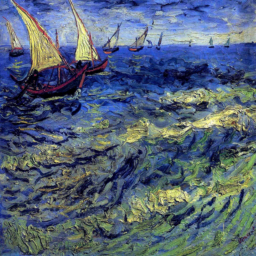

In [54]:
style_image = load_image(STYLE_IMAGE)
show_image(style_image)

"Fishing Boats at Sea" by Vincent van Gogh. (one of my favorite artist tho U_U)

## Model
The architecture is quite simple and have explained in detail in the paper for the implementation.\
You can check the implemention [here](https://github.com/emanalytic/Perceptual-Losses-Neural-Style-Transfer/blob/main/scripts/transformer_network.py)!

In [10]:
network = ImageTransformerNet().to(DEVICE)

**For the loss network, the pre-trained VGG-16 model architecture will be used as suggested by Johnson et. al's in the paper**

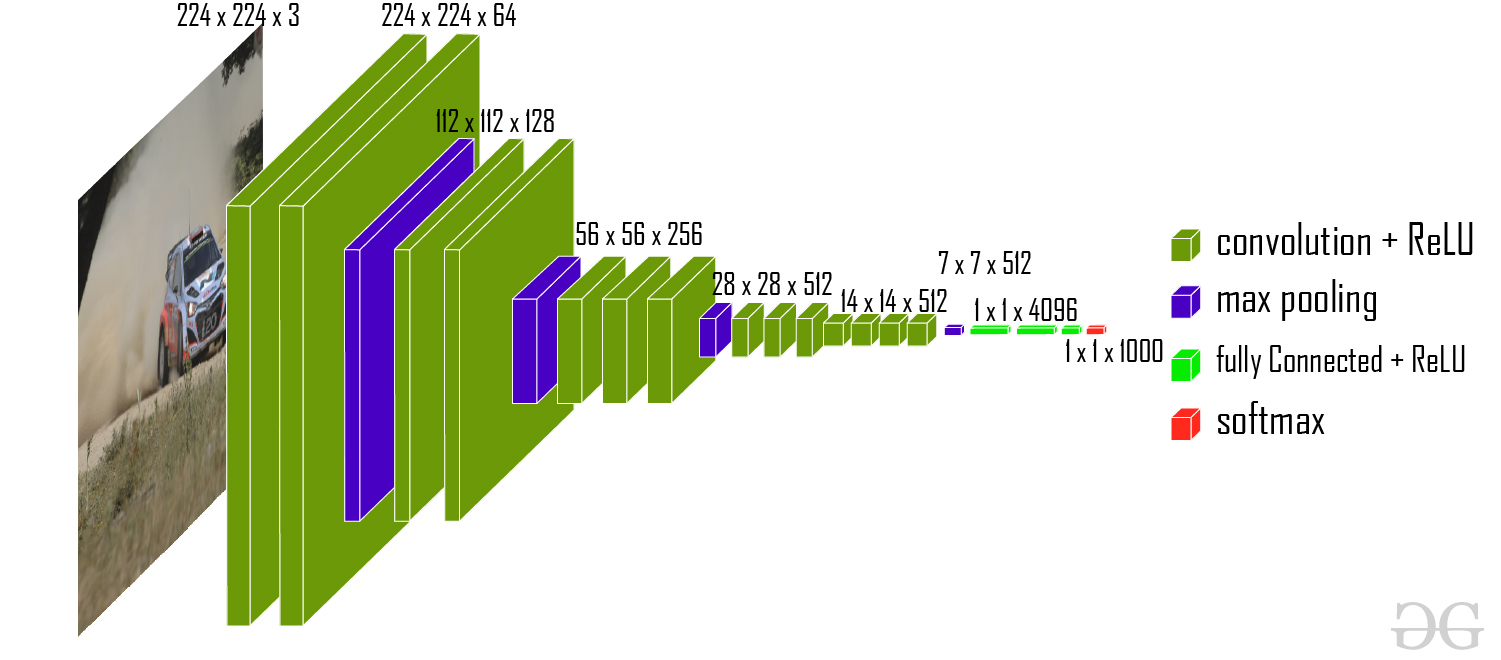

In [57]:
vgg = vgg16(weights=VGG16_Weights.DEFAULT).features.to(DEVICE).eval()

for params in vgg.parameters():
    params.requires_grad = False

In [58]:
class ForwardHookManager:
    def __init__(self, model, layer_indices):
        self.hooks = [list(model.children())[index].register_forward_hook(self.forward_hook) for index in layer_indices]
        self.clear_outputs()

    def __del__(self):
        for hook in self.hooks:
            hook.remove()

    def forward_hook(self, module, input, output):
        self.layer_outputs.append(output)

    def clear_outputs(self):
        self.layer_outputs = []

## How do the hooks  Work Internally?
When we call model(input), PyTorch runs the model’s forward pass.
For each layer with a registered hook, PyTorch triggers the corresponding hook function (`forward_hook`).
Inside the `forward_hook` function, the output of the layer is captured and stored in `self.layer_outputs`.
This process happens automatically during the forward pass without you needing to explicitly iterate through layers or manage the flow of data.

its dynamic and automatic, using hooks to capture the outputs from the layers during the forward pass without modifying the model’s forward method.

In [59]:
hook_manager = ForwardHookManager(vgg, LAYER_IDS)

## Loss Network

So the main difference between the Gatys' original style transfer [Paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) uses pixel-wise losses for content (direct pixel comparison) and style (Gram matrix comparison), while this   Loss focuses on comparing high-level features from pre-trained networks, not pixel values.


# Feature Reconstruction Loss

- **Loss Network (φ)**: This is a network that helps us evaluate the features of an image.
- **Feature Map (φj(x))**: When we input an image `x` into the loss network, it gives us activations from different layers. For the j-th layer, the output is called a feature map, which has the shape:
  - **Cj**: Number of channels in the feature map
  - **Hj**: Height of the feature map
  - **Wj**: Width of the feature map

## Working
Instead of making sure the pixels in our output image (let’s call it `ˆy`) match perfectly with the target image (`y`), we focus on making their features similar.
The feature reconstruction loss measures how similar the features of `ˆy` and `y` are. It does this by calculating the squared difference [Euclidean distance](https://medium.com/@emanisar/how-important-is-linear-algebra-for-deep-learning-part-1-of-3-4f70cce71d27#:~:text=of%20Distance%20Metric%3A-,Euclidean%20Distance%3A,-Derived%20from%20the) between the feature maps, and then normalizing this value.

This actually helps to ensure that the essential characteristics and patterns in the images are preserved.. even if the pixel values aren't exactly the same.


In [60]:
class FeatureReconstructionLoss(nn.Module):
    def __init__(self):
        super(FeatureReconstructionLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, y_hat, y):
        return self.mse_loss(y_hat, y)


# Style Reconstruction Loss

Style loss measures how different the style of the generated image is from the style image. This is done using Gram Matrices, which capture correlations between feature maps.

## Gram Matrices

Gram matrix for a set of feature maps, which is a square matrix that captures the correlations between different feature maps in a convolutional neural network.


### Example

Let’s assume we have a feature map from a convolutional layer of an image with the following properties:
- \(C = 3\) (3 channels),
- \(H = 4\) (height of each feature map),
- \(W = 4\) (width of each feature map).

So, the feature map is of shape **(3, 4, 4)**.

### Initial Feature Map
You can think of the feature map as a 3D tensor, where each channel is a 2D matrix (height x width):

$$
\text{Feature Map} = \left[\begin{array}{ccc}
\text{Channel 1} & \text{Channel 2} & \text{Channel 3} \\
\end{array}\right]
$$

Each channel looks like this:

$$
\text{Channel 1 (4x4)} = \begin{bmatrix}
f_{11} & f_{12} & f_{13} & f_{14} \\
f_{21} & f_{22} & f_{23} & f_{24} \\
f_{31} & f_{32} & f_{33} & f_{34} \\
f_{41} & f_{42} & f_{43} & f_{44} \\
\end{bmatrix}
$$

$$
\text{Channel 2 (4x4)} = \begin{bmatrix}
g_{11} & g_{12} & g_{13} & g_{14} \\
g_{21} & g_{22} & g_{23} & g_{24} \\
g_{31} & g_{32} & g_{33} & g_{34} \\
g_{41} & g_{42} & g_{43} & g_{44} \\
\end{bmatrix}
$$

$$
\text{Channel 3 (4x4)} = \begin{bmatrix}
h_{11} & h_{12} & h_{13} & h_{14} \\
h_{21} & h_{22} & h_{23} & h_{24} \\
h_{31} & h_{32} & h_{33} & h_{34} \\
h_{41} & h_{42} & h_{43} & h_{44} \\
\end{bmatrix}
$$

### Flattening Each Channel
Now, each channel is flattened into a vector of size \(H \times W = 4 \times 4 = 16\). So, each of the 3 channels becomes a 1D vector:

$$
\text{Channel 1 (flattened)} = \begin{bmatrix}
f_{11} & f_{12} & f_{13} & f_{14} & f_{21} & f_{22} & f_{23} & f_{24} & f_{31} & f_{32} & f_{33} & f_{34} & f_{41} & f_{42} & f_{43} & f_{44}
\end{bmatrix}
$$

$$
\text{Channel 2 (flattened)} = \begin{bmatrix}
g_{11} & g_{12} & g_{13} & g_{14} & g_{21} & g_{22} & g_{23} & g_{24} & g_{31} & g_{32} & g_{33} & g_{34} & g_{41} & g_{42} & g_{43} & g_{44}
\end{bmatrix}
$$

$$
\text{Channel 3 (flattened)} = \begin{bmatrix}
h_{11} & h_{12} & h_{13} & h_{14} & h_{21} & h_{22} & h_{23} & h_{24} & h_{31} & h_{32} & h_{33} & h_{34} & h_{41} & h_{42} & h_{43} & h_{44}
\end{bmatrix}
$$

### Stacking the Flattened Vectors
Now, we stack the 3 flattened vectors (one for each channel) to form a matrix of size \(C \times (H \times W)\), i.e., a matrix of size \(3 \times 16\):

$$
\text{Feature Map (reshaped)} = \begin{bmatrix}
f_{11} & f_{12} & \dots & f_{44} \\
g_{11} & g_{12} & \dots & g_{44} \\
h_{11} & h_{12} & \dots & h_{44}
\end{bmatrix}
$$

This reshaped matrix has **3 rows** (one for each channel) and **16 columns** (one for each pixel in the feature map).

### Computing the Gram Matrix
The **Gram matrix** is computed by taking the dot product of this reshaped matrix with its transpose. This allows us to capture the correlations between the features in the different channels.

The **Gram matrix** \(G\) is computed as:

$$
G = \text{Feature Map} \times \text{Feature Map}^T
$$

Where:
$$
\text{Feature Map}^T \text{ (transpose)} = \begin{bmatrix}
f_{11} & g_{11} & h_{11} \\
f_{12} & g_{12} & h_{12} \\
\vdots & \vdots & \vdots \\
f_{44} & g_{44} & h_{44}
\end{bmatrix}
$$

Note:  The reason we transpose the feature map before calculating the Gram matrix is to ensure that we are capturing the correlations between features across different channels, not between features within the same channel.

### Resulting Gram Matrix
The result of multiplying the reshaped feature map matrix with its transpose gives us the **Gram matrix**, which captures the correlations between the different channels of the feature map.

$$
G = \begin{bmatrix}
\text{Gram matrix element} & \dots \\
\vdots & \ddots \\
\end{bmatrix}
$$

This Gram matrix is used in style transfer to measure similarity between the features of the image at different layers.

In [61]:
class StyleReconstructionLoss(nn.Module):
    def __init__(self):
        super(StyleReconstructionLoss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, prediction, target):
        prediction_gram_matrix = self.gram_matrix(prediction)
        target_gram_matrix = self.gram_matrix(target)

        return self.mse_loss(prediction_gram_matrix, target_gram_matrix)
        
    def gram_matrix(self, y):
        b, ch, h, w = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram

# Final Loss (Perceptual Loss)

In [63]:
class PerceptualLoss(nn.Module):
    def __init__(self, alpha, beta):
        super(PerceptualLoss, self).__init__()

        self.alpha = alpha
        self.beta = beta
        self.style_loss = StyleReconstructionLoss()
        self.feature_loss = FeatureReconstructionLoss()

    def forward(self, y_hat, y_style, y_content):
        style_loss = 0.0
        feature_loss = self.alpha * self.feature_loss(y_hat[FEATURE_INDEX], y_content[FEATURE_INDEX].detach())

        for current_y_hat, current_y_style in zip(y_hat, y_style):
            style_loss += self.style_loss(current_y_hat, current_y_style[:len(current_y_hat)].detach())

        style_loss *= self.beta

        return feature_loss + style_loss

## Optimizers and loss function
As defined in Johnson et. al's (2016) paper, they used a learning rate of 1e-3 with the Adam optimizer.

In [ ]:
loss_function = PerceptualLoss(ALPHA, BETA)

In [14]:
optimizer = optim.Adam(network.parameters(), lr=LR)

## Training

In [66]:
def train(
        dataloader,
        network,
        vgg,
        loss_function,
        optimizer,
        style_image,
        hook_manager,
        n_epochs,
        DEVICE='cuda',
        BATCH=32,
):
    network.train()
    total_steps = n_epochs * len(dataloader)
    progress_bar = tqdm(total=total_steps, desc="Training Progress", unit="step")

    for epoch in range(1, n_epochs + 1):
        total_loss = []
        for image in dataloader:
            torch.cuda.empty_cache()  

            optimizer.zero_grad()
            image = image.to(DEVICE, non_blocking=True) 

            y_hat = network(image)
            vgg(y_hat)
            y_hat = hook_manager.layer_outputs
            hook_manager.clear_outputs()

            vgg(image)
            y_content = hook_manager.layer_outputs
            hook_manager.clear_outputs()

            style_target = style_image.to(DEVICE).repeat(BATCH, 1, 1, 1)
            vgg(style_target)
            y_style = hook_manager.layer_outputs
            hook_manager.clear_outputs()

            loss = loss_function(y_hat, y_style[:len(y_hat)], y_content)
            total_loss.append(loss.item())
            loss.backward()

            optimizer.step()

            del y_hat, y_content, y_style, style_target
            torch.cuda.empty_cache()

            avg_loss = sum(total_loss) / len(total_loss)
            progress_bar.set_postfix(loss=f"{avg_loss:.4f}")
            progress_bar.update(1)

    progress_bar.close()
    del hook_manager  
    torch.cuda.empty_cache()  

In [67]:
n_epochs = 2
train(dlr, network,vgg,
            loss_function,
            optimizer,
            style_image,
            hook_manager,
            n_epochs)

Training Progress: 100%|██████████| 3000/3000 [16:20<00:00,  3.06step/s, loss=1294.9542]


In [76]:
def save_model_checkpoint(model, optimizer, epoch, filename):
    checkpoint = {MODEL_KEY: model.state_dict(),
                  OPTIMIZER_KEY: optimizer.state_dict(),
                  EPOCH_KEY: epoch}
    torch.save(checkpoint, MODEL_CHECKPOINT_FILEPATH.format(filename))


def load_model_checkpoint(model, optimizer, filename):
    model_checkpoint = torch.load(MODEL_CHECKPOINT_FILEPATH.format(filename))
    model_state_dict, optimizer_state_dict = (model_checkpoint[MODEL_KEY],
                                              model_checkpoint[OPTIMIZER_KEY])
    model.load_state_dict(model_state_dict)
    optimizer.load_state_dict(optimizer_state_dict)

def style_image(model, image, filename=None):
    model.eval()
    image = image.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        styled_image = model(image)

    styled_image_pil = show_image(styled_image)
    styled_image_pil.save(filename)
    return styled_image_pil

In [77]:
save_model_checkpoint(network, optimizer, 2, "style-transfer-alpha1e5-beta1e10-epoch-2")

In [17]:
load_model_checkpoint(network, optimizer, 'style-transfer-alpha1e5-beta1e10-epoch-2.pth')

Checkpoint loaded from /kaggle/input/style-transfer/pytorch/default/1/style-transfer-alpha1e5-beta1e10-epoch-2.pth, starting from epoch 2


<ipython-input-17-3576f93cca4a>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_checkpoint = torch.load(filepath)


2

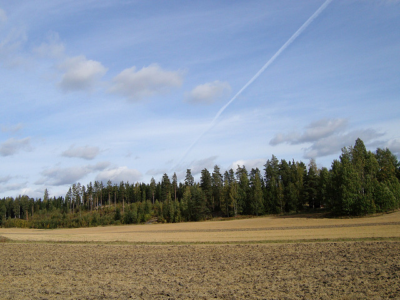

In [27]:
test_image = load_image('test_image_01.png')
show_image(test_image)

Styled image saved to styled_image.png


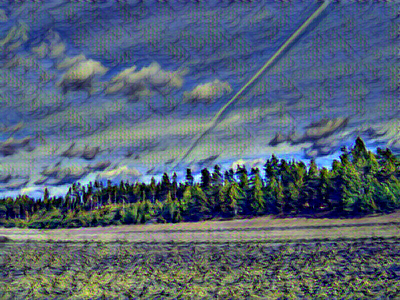

In [29]:
style_image(network, test_image, filename='styled_image.png')

tadaa!